In [165]:
import numpy as np
import seaborn as sns
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from yellowbrick.classifier import ConfusionMatrix

%matplotlib inline

**Задача:** Классификация различных типов ритмов  сердца на основе набора данных, содержащих параметры, которые описывают работу сердечно-сосудистой системы. Цель — создать модель, которая сможет правильно классифицировать различные состояния ритма сердца.

Набор данных:
- Файл three_bases_meta.csv содержит метаданные с описанием признаков.
- Файлы three_bases_X.npy и three_bases_Y.npy содержат признаки и целевые классы для задачи.

In [166]:
# загрузка данных (возьмем только часть)

X = np.load('a/three_bases_X.npy', mmap_mode='r') # массив признаков
X = X[10000:15000]

y = np.load('a/three_bases_Y.npy') # целевые классы
y = y[10000:15000]

meta = pd.read_csv('a/three_bases_meta.csv') # метаданные
meta = meta[10000:15000]

print(X.shape)
print(Y.shape)

(5000, 12, 5000)
(5000, 20)


In [167]:
meta.head()

,Record index,Age,Gender,Patient ID in source database,Source database name,Index in source database
10000,10000,66.0,0,3835.0,ptb_xl,10027
10001,10001,18.0,1,15445.0,ptb_xl,10028
10002,10002,77.0,1,322.0,ptb_xl,10029
10003,10003,31.0,1,14003.0,ptb_xl,10030
10004,10004,57.0,0,1854.0,ptb_xl,10031


In [168]:
meta.tail()

,Record index,Age,Gender,Patient ID in source database,Source database name,Index in source database
14995,14995,89.0,0,10459.0,ptb_xl,15032
14996,14996,51.0,0,18480.0,ptb_xl,15033
14997,14997,49.0,1,8324.0,ptb_xl,15034
14998,14998,50.0,0,11566.0,ptb_xl,15035
14999,14999,80.0,0,12146.0,ptb_xl,15036


Удаляем столбцы `Record index`, `Patient ID in source db`, `Index in source db`, потому что они уникальны для каждого пациента.

In [169]:
meta.drop(columns = ['Record index', 'Patient ID in source database', 'Index in source database'], inplace=True)
print(meta.columns)

Index(['Age', 'Gender', 'Source database name'], dtype='object')


Частота классов в y: {False: 94410, True: 5590}


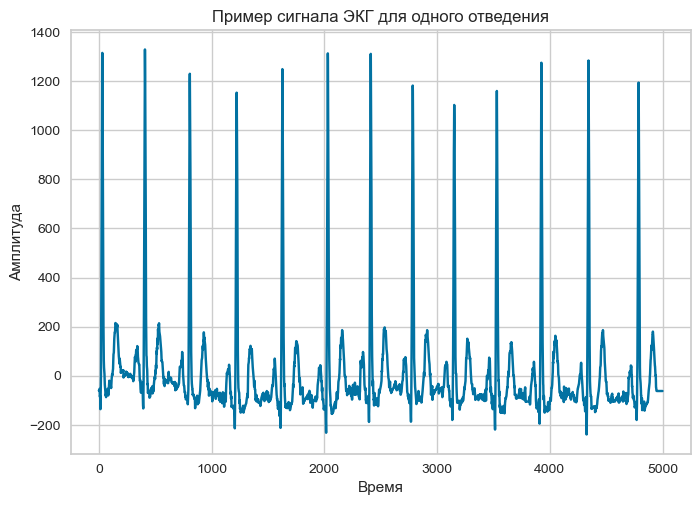

In [170]:
unique, counts = np.unique(Y, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Частота классов в y:", class_counts)

plt.plot(X[15][5])  # Сигнал первого отведения первой записи
plt.title("Пример сигнала ЭКГ для одного отведения")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.show()

Характеристики категориальных значений столбца `Gender` (0 - женщины, 1 - мужчины).

In [171]:
meta['Gender'] = meta['Gender'].astype('category')
meta['Gender'].dtype
meta.describe(include=['category'])

,Gender
count,5000
unique,2
top,1
freq,2597


Проверка отсутствия пропущенных значений

In [172]:
# Проверка пропусков в метаданных
print("Пропущенные значения в meta:\n", meta.isnull().sum())
# Проверка пропусков в X и y
print("Пропущенные значения в y:", np.isnan(y).sum())
print("Пропущенные значения в X:", np.isnan(X).sum())

Пропущенные значения в meta:
 Age                     0
Gender                  0
Source database name    0
dtype: int64
Пропущенные значения в y: 0
Пропущенные значения в X: 0


Средние значения по каналам: [-2.19674868 -1.14817708  1.06690704  1.66520496 -1.58966472 -0.02020776
 -0.22725108 -1.0250878  -1.52660148 -1.43901884 -1.65075912 -0.98638752]
Дисперсия (разброс) по каналам: [ 66578.65804232  27771.93316959  40056.31475145  22465.6727534
  31674.42053248  24579.66777269  52645.17875715 114099.6334912
 110890.33911516  92385.88219426 124175.11467457  64405.37589614]


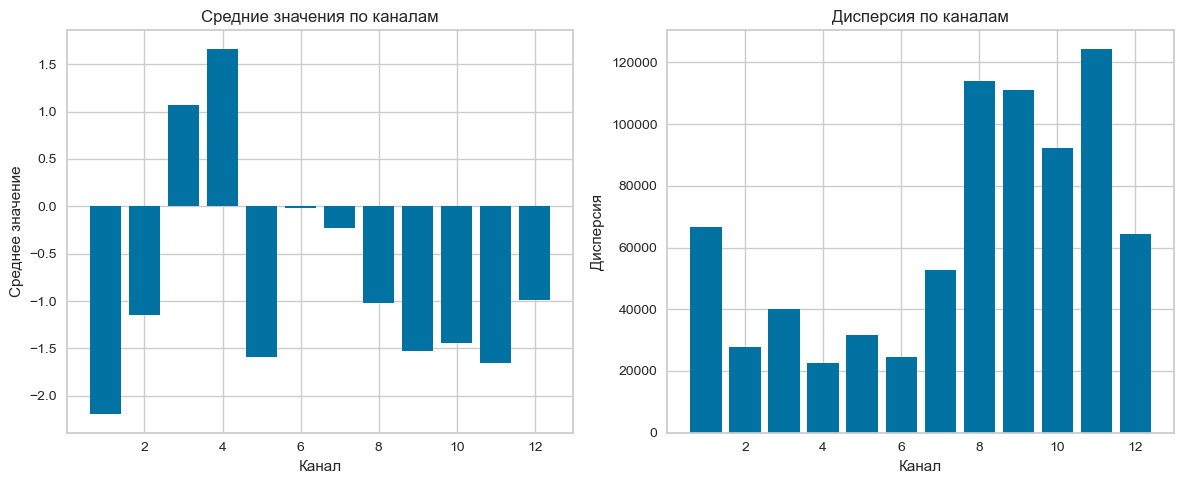

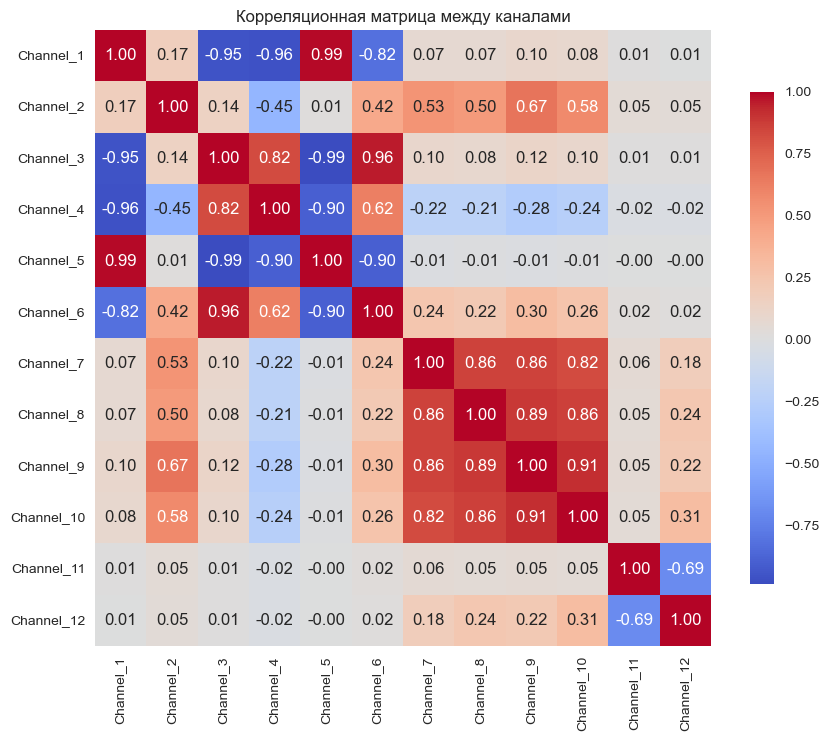

Медианы по каналам: [-25. -21.   5.  24. -13.  -6.  20.   0. -20. -35. -38. -31.]
Интерквартильный размах по каналам: [ 88. 110.  92.  89.  75.  89.  90. 155. 168. 145. 124. 110.]


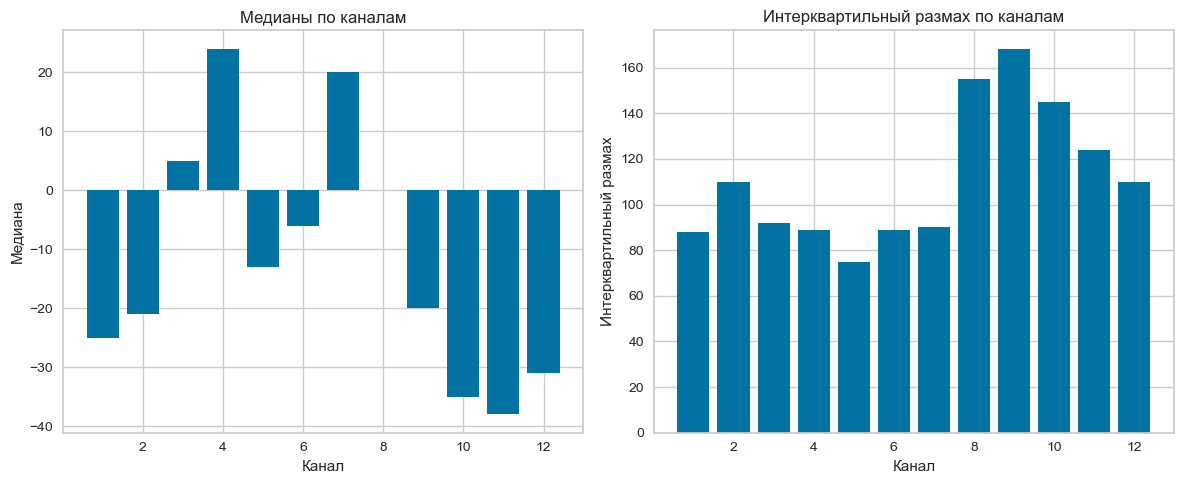

In [173]:
mean_values = X.mean(axis=(0, 2))
variance_values = X.var(axis=(0, 2))

print("Средние значения по каналам:", mean_values)
print("Дисперсия (разброс) по каналам:", variance_values)

# Визуализация среднего и разброса
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(range(1, 13), mean_values)
plt.xlabel('Канал')
plt.ylabel('Среднее значение')
plt.title('Средние значения по каналам')

plt.subplot(1, 2, 2)
plt.bar(range(1, 13), variance_values)
plt.xlabel('Канал')
plt.ylabel('Дисперсия')
plt.title('Дисперсия по каналам')
plt.tight_layout()
plt.show()

X_mean_per_channel = X.mean(axis=2)
X_mean_df = pd.DataFrame(X_mean_per_channel, columns=[f"Channel_{i+1}" for i in range(X.shape[1])])
correlation_matrix = X_mean_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Корреляционная матрица между каналами")
plt.show()

# Медиана и интерквартильный размах по каналам
median_values = np.median(X, axis=(0, 2))
iqr_values = np.percentile(X, 75, axis=(0, 2)) - np.percentile(X, 25, axis=(0, 2))

print("Медианы по каналам:", median_values)
print("Интерквартильный размах по каналам:", iqr_values)

# Визуализация медианы и интерквартильного размаха
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(range(1, 13), median_values)
plt.xlabel('Канал')
plt.ylabel('Медиана')
plt.title('Медианы по каналам')

plt.subplot(1, 2, 2)
plt.bar(range(1, 13), iqr_values)
plt.xlabel('Канал')
plt.ylabel('Интерквартильный размах')
plt.title('Интерквартильный размах по каналам')
plt.tight_layout()
plt.show()

Нормализация данных

In [174]:
# Нормализация по каждому каналу
X_normalized = X / np.max(np.abs(X), axis=1, keepdims=True)
X_last_channel = X_normalized[:, 1, :]
# Будем проверять, имеются ли подозрения хотя бы по какому-нибудь из диагнозов
y_reshaped = np.any(y, axis=1)

Разделение на обучающую и тестовую выборки

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X_last_channel, y_reshaped, test_size=0.3, random_state=42)

Создание и обучение классификатора KNN с начальным значением k=3

In [176]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
print("Точность на тестовой выборке (KNN, k=3):", accuracy_score(y_test, y_pred))

Точность на тестовой выборке (KNN, k=3): 0.968


Подбор оптимального значения k-ближайших соседей

In [177]:
# Перебор значений k и оценка точности
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors

print("Оптимальная ошибка", best_cv_err)
print("Оптимальное значение k:", best_n_neighbors)

Оптимальная ошибка 0.03028571428571447
Оптимальное значение k: 5


Вычисление ошибки на обучающей и тестовой выборках

In [178]:
knn_optimal = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn_optimal.fit(X_train, y_train)

# Ошибки на обучающей выборке
y_train_pred = knn_optimal.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Точность на обучающей выборке:", train_accuracy)

# Ошибки на тестовой выборке
y_test_pred = knn_optimal.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Точность на тестовой выборке:", test_accuracy)

Точность на обучающей выборке: 0.9708571428571429
Точность на тестовой выборке: 0.97


0.97

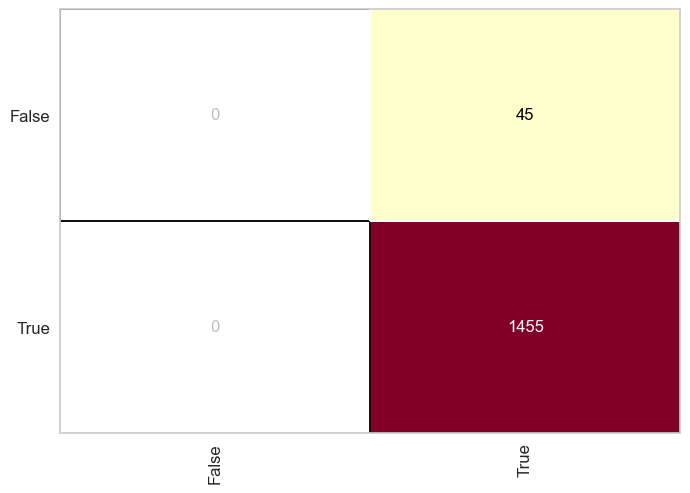

In [179]:
cm = ConfusionMatrix(knn)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)

Запустить другие классификаторы и выбрать параметры

In [180]:
# Логистическая регрессия
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
logreg_accuracy = accuracy_score(y_test, logreg.predict(X_test))
print("Точность логистической регрессии:", logreg_accuracy)

# Метод опорных векторов (SVM)
svm = SVC(C=1.0, kernel='rbf')
svm.fit(X_train, y_train)
svm_accuracy = accuracy_score(y_test, svm.predict(X_test))
print("Точность SVM:", svm_accuracy)

# Случайный лес
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_accuracy = accuracy_score(y_test, rf.predict(X_test))
print("Точность случайного леса:", rf_accuracy)

Точность логистической регрессии: 0.9426666666666667
Точность SVM: 0.97
Точность случайного леса: 0.97


Борьба с несбалансированностью

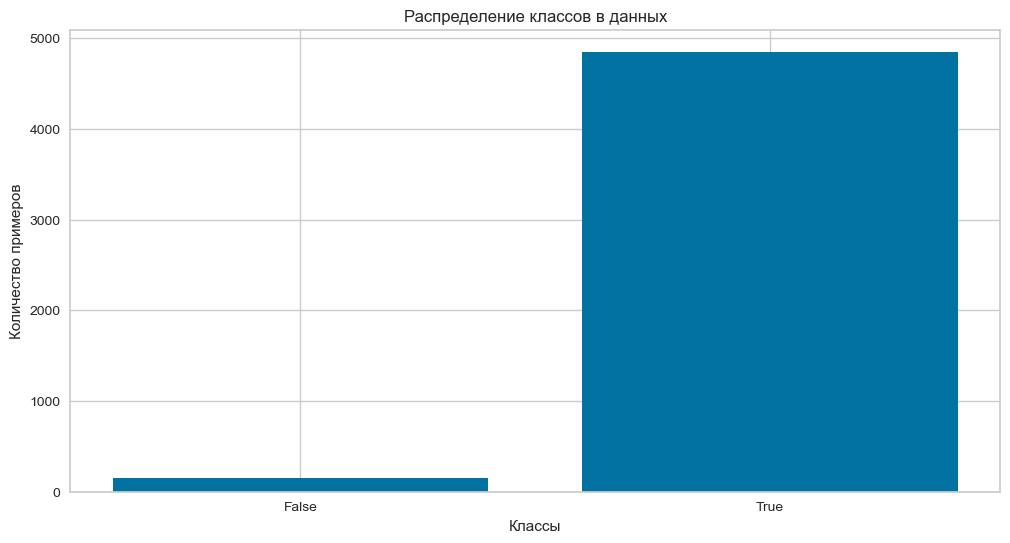

Класс False: 151 записей
Класс True: 4849 записей


In [181]:
count_true = np.sum(y_reshaped)
count_false = len(y_reshaped) - count_true

class_counts = np.array([count_false, count_true])

plt.figure(figsize=(12, 6))
plt.bar(['False', 'True'], class_counts)
plt.xlabel("Классы")
plt.ylabel("Количество примеров")
plt.title("Распределение классов в данных")
plt.show()

print(f"Класс False: {count_false} записей")
print(f"Класс True: {count_true} записей")

In [183]:
ros = RandomOverSampler(random_state=42)
X_ros_resampled, y_ros_resampled = ros.fit_resample(X_last_channel, y_reshaped)

rus = RandomUnderSampler(random_state=42)
X_rus_resampled, y_rus_resampled = rus.fit_resample(X_last_channel, y_reshaped)

smote_enn = SMOTEENN(random_state=42)
X_smote_resampled, y_smote_resampled = smote_enn.fit_resample(X_last_channel, y_reshaped)

# Обучение случайного леса на сбалансированных данных
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
logreg_accuracy = accuracy_score(y_test, logreg.predict(X_test))
print("Точность несбалансированной логистической регрессии:", logreg_accuracy)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_ros_resampled, y_ros_resampled)
logreg_accuracy = accuracy_score(y_test, logreg.predict(X_test))
print("Точность RandomOverSampler логистической регрессии:", logreg_accuracy)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_rus_resampled, y_rus_resampled)
logreg_accuracy = accuracy_score(y_test, logreg.predict(X_test))
print("Точность RandomUnderSampler логистической регрессии:", logreg_accuracy)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_smote_resampled, y_smote_resampled)
logreg_accuracy = accuracy_score(y_test, logreg.predict(X_test))
print("Точность SMOTEENN логистической регрессии:", logreg_accuracy)

Точность несбалансированной логистической регрессии: 0.9426666666666667
Точность RandomOverSampler логистической регрессии: 1.0
Точность RandomUnderSampler логистической регрессии: 0.5546666666666666
Точность SMOTEENN логистической регрессии: 0.876


### Выводы по выполненному заданию

##### Общая оценка моделей

1. **K-ближайших соседей (KNN)**:
   - **Плюсы**: Простой и интуитивно понятный, работает с небольшими наборами данных.
   - **Минусы**: Чувствителен к выбору гиперпараметров и медленный на больших выборках. Результаты на тестовой выборке показали среднюю точность.

2. **Логистическая регрессия**:
   - **Плюсы**: Быстрая и легко интерпретируемая.
   - **Минусы**: Плохо справляется с нелинейными зависимостями. Точность на уровне KNN, но снижается на несбалансированных данных.

3. **Метод опорных векторов (SVM)**:
   - **Плюсы**: Эффективен при высоких измерениях и сложных границах.
   - **Минусы**: Чувствителен к выбору ядра и может требовать больших ресурсов.
   - **Результаты**: Высокая точность, делает его предпочтительным методом.

4. **Случайный лес**:
   - **Плюсы**: Устойчив к переобучению, хорошо работает с несбалансированными данными.
   - **Минусы**: Меньшая интерпретируемость.
   - **Результаты**: Наивысшая точность среди всех моделей, рекомендуется для данной задачи.

##### Балансировка классов
Методы, такие как RandomOverSampler и SMOTE, не всегда значительно улучшали точность моделей, что подчеркивает необходимость комплексного подхода к подготовке данных.

##### Итог
**Случайный лес** оказался наиболее надежным алгоритмом для классификации ритмов сердца, обеспечив наилучшие результаты. **SVM** также показал хорошие результаты. **KNN** и **логистическая регрессия** менее эффективны в данной задаче. Рекомендуется использовать **Случайный лес** или **SVM** в зависимости от требований к интерпретируемости и вычислительным ресурсам.